In [1]:
from pyraf import iraf
from iraf import obsutil
import subprocess
from astropy.table import Table
import os
import csv
#in the furture make packages and import common functions
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from pyraf import gwm
from astropy.io import ascii
import numpy as np
from astropy.stats import sigma_clip
from iraf import psfmeasure

In [2]:
imagename = '/data/mj1e16/kepler/cal/kplr2009114174833_ffi-cal.fits'

In [3]:
def makeConfig(valList,defaultDir='/home/mj1e16/sextractor/sextractor-master/config/',attributeList=['DETECT_THRESH','DETECT_MINAREA','BACK_FILTERSIZE','BACK_SIZE']):
    
    with open(defaultDir+'/default.sex','r') as f:
        data  = f.read()
    
    catLocFinder = 'CATALOG_NAME'
    catname = 'test_PSF.cat'
    nameLoc = data.find(catLocFinder) + len(catLocFinder)
    endLoc = data[nameLoc:].find('#') + nameLoc
    newData = data[:nameLoc] + ' '+catname+' ' + data[endLoc:]
    data = newData 
        
    for x in range(len(valList)):
        nameLoc = data.find(attributeList[x]) + len(attributeList[x])
        endLoc = data[nameLoc:].find('#') + nameLoc
        newData = data[:nameLoc] + ' '+str(valList[x])+' ' + data[endLoc:]
        data = newData    
    
    
    confName = 'default_PSF.sex'
    with open(defaultDir+confName,'w') as f:
        f.write(data)
    return(confName,catname)

In [4]:
def findObjects(imagename,ext,confName,catName,defaultDir='/home/mj1e16/sextractor/sextractor-master/config/'):
    
    os.chdir(defaultDir)
    subprocess.call(['sex',imagename+'[{}]'.format(ext),'-c',confName])
    assoc = Table.read(catName,format='ascii.sextractor')
    
    return assoc

In [5]:
def cleanLogFile(logfile,imageName='/data/mj1e16/ke'): # imagename up to a max of 15 chars
    with open(logfile,'r') as f:
        string = f.read()

    string = string.replace('NOAO/IRAF V2.16','#NOAO/IRAF V2.16')
    string = string.replace('Image','     ')
    string = string.replace(imageName,'               ')
    string = string.replace('SAT','')
    string = string.replace('Average','#Average')

    with open(logfile,'w') as f:
        f.write(string)

In [6]:
def findPSF(outTable,imageName,extension,imageshape=[1070., 1132.],pixelsize=3.98):
    imageName += '[{}]'.format(extension)
    print(imageName)
    df = outTable.to_pandas()
#     print(len(df))
#     dfslim = df #.loc[df['ELLIPTICITY'] <= 0.1]
#     dflen = len(dfslim)
#     top10 = int(dflen/5)
#     newdf = dfslim.nlargest(top10,'FLUX_ISO')
#     df2 = newdf[50:top10]
    df2 = df
    print(len(df2))
    os.chdir('/home/mj1e16/iraf/')
    
    xlength = imageshape[0]
    ylength = imageshape[1]
    nsegs = 15
    
    xsegment = xlength/nsegs
    ysegment = ylength/nsegs
    #print(xsegment)
    PSF = []
    for xsegs in range(nsegs):
        lowx = xsegs*xsegment
        highx = lowx+xsegment
        psf = []
        for ysegs in range(nsegs):
            #print(lowx,highx)
            irafLog = 'logfile_{}_x{}_y{}'.format(extension,xsegs,ysegs)
            
            lowy = ysegs*ysegment
            highy = lowy+ysegment
            regiondf = df2.loc[(df2['Y_IMAGE'] >= lowy) & (df2['Y_IMAGE'] <= highy) & (df2['X_IMAGE'] >= lowx) & (df2['X_IMAGE'] <= highx)]
            xcoords = regiondf['X_IMAGE'].tolist()
            ycoords = regiondf['Y_IMAGE'].tolist()
            print(len(xcoords),xsegs,ysegs)
            with open('starlist','w') as f:
                writer = csv.writer(f,delimiter=' ')
                writer.writerows(zip(xcoords,ycoords))

            with open('starlist','a') as f:
                f.write('q')
            if len(xcoords) >= 9:
                with open('logfile_{}_x{}_y{}'.format(extension,xsegs,ysegs),'w') as f:
                    f.write('')
                psfmeasure(imageName,coords='markall',logfile=irafLog,imagecur='starlist') 
                cleanLogFile(irafLog)
                data = ascii.read(irafLog,guess=False)
                fwhm = data['FWHM']
                filtered_data = sigma_clip(fwhm, sigma=3, iters=5)
                psf.append(np.median(filtered_data)*pixelsize)


            else:
                print('Not enough in region {} {}'.format(xsegs,ysegs))
                psf.append(0) #'N/A')
        PSF.append(psf)
            
    return PSF

In [17]:
def findPSFFullImage(outTable,imageName,extension,imageshape=[1070., 1132.],pixelsize=3.98):
    imageName += '[{}]'.format(extension)
    print(imageName)
    df = outTable.to_pandas()
#     print(len(df))
#     dfslim = df #.loc[df['ELLIPTICITY'] <= 0.1]
#     dflen = len(dfslim)
#     top10 = int(dflen/5)
    newdf = df.nlargest(200,'FLUX_ISO')
    df2 = newdf[50:100]
    #df2 = df
    print(len(df2))
    os.chdir('/home/mj1e16/iraf/')
    xcoords = df2['X_IMAGE'].tolist()
    ycoords = df2['Y_IMAGE'].tolist()
    
    irafLog = 'logfile_{}'.format(extension)
    with open('logfile_{}'.format(extension),'w') as f:
        f.write('')
    with open('starlist','w') as f:
        writer = csv.writer(f,delimiter=' ')
        writer.writerows(zip(xcoords,ycoords))

    with open('starlist','a') as f:
        f.write('q')
                
    psfmeasure(imageName,coords='markall',logfile=irafLog,imagecur='starlist') 
    cleanLogFile(irafLog)
    data = ascii.read(irafLog,guess=False)
    fwhm = data['FWHM']
    filtered_data = sigma_clip(fwhm, sigma=3, iters=5)
    psf = np.median(filtered_data)*pixelsize
            
    return psf

In [ ]:
def psfModel():
    

In [8]:
# def findAveragePSF(): # not a real function just saving code incase
#     with open('logfile_{}_x{}_y{}'.format(extension,xsegs,ysegs),'r') as f:
#         bigstring = f.read()
#     finder = 'Average full width at half maximum (FWHM) of '
#     loc1 = bigstring.find(finder) +len(finder)
#     loc2 = bigstring[loc1:].find('\n')
#     print(loc1,loc2)
#     PSF[xsegs].append(bigstring[loc1:loc1+loc2])

In [10]:
names = makeConfig([5,10,3,64])
#outTable = findObjects(imagename,44,names[0],names[1])

In [11]:
extensions = [44,63,9]
psf = []


for ext in extensions:
    outTable = findObjects(imagename,ext,names[0],names[1])
    psf.append(findPSF(outTable,imagename,ext))

/data/mj1e16/kepler/cal/kplr2009114174833_ffi-cal.fits[44]
8395
(25, 0, 0)
z1=43.74463 z2=304.1827
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Fri 14:01:01 14-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke   22.00   20.54    4.52   1.490    0.12       0
                  21.20   36.19    1.91  19.295    0.25     -75
                  66.42   20.86    3.53   0.993    0.91     -59
                  22.00   20.54    4.53   1.490    0.11       0
                  59.72   39.60    0.01  16.028    0.63      -4
                  25.26   26.59    2.73  16.548    0.10      13
                  25.23   26.80    2.61  16.538    0.11      13
                  26.19   45.51    3.97  20.275    0.40      54
                  17.34   43.25    4.19   1.111    0.10     -85
                  55.89   39.63    4.27   1.410    0.34      16
                  67.06   39.

/home/mj1e16/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


NOAO/IRAF V2.16 mj1e16@uos-201660 Fri 14:01:10 14-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke   19.93   88.41    3.16  15.288    0.67     -43
                  30.43   78.46    3.62   3.880    0.19       2
                  31.20   80.38    4.45   1.819    0.19      63
                  30.43   78.46    3.62   3.880    0.19       2
                  70.94   79.69    6.27   1.237    0.78     -50
                  45.61   84.74    3.98   2.986    0.13     -27
                  44.70   84.75    3.72   2.454    0.25      -7
                  44.70   84.75    3.72   2.454    0.25      -7
                  58.81   86.04    6.92   1.282    0.60     -15
                  55.83   96.84    7.17   1.256    0.90      -9
                  14.21   92.30    3.28   1.111    0.05      55
                  68.82   90.79    4.14   1.293    0.29     -66
                  27.38   87.03    2.49  30.593    0.50     -16
                  48.36  100.53    5.79 

                  74.77  367.12    5.49   1.492    0.83       8
                  62.98  370.86    4.65   2.522    0.45      48
                  62.98  370.90    4.64   2.532    0.46      48
                  46.38  366.73    1.18   1.143    0.09     -58
                  46.38  366.73    1.18   1.143    0.09     -58

  Average full width at half maximum (FWHM) of 11.4163
(24, 0, 5)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Fri 14:01:25 14-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke   55.07  379.99    5.88   0.946    0.00       0
                  44.93  380.70    2.85   1.037    0.12     -72
                  61.07  384.97    4.42   1.050    0.04      10
                  13.08  385.79    4.06   0.934    0.00       0
                  48.87  390.51    4.03   1.166    0.19     -44
                  65.21  393.42    5.05   1.666    0.72      

Killing IRAF task `psfmeasure'


KeyboardInterrupt: 

In [20]:
extensions = [44,63,79]
psf = []
for ext in extensions:
    outTable = findObjects(imagename,ext,names[0],names[1])
    psf.append(findPSFFullImage(outTable,imagename,ext))

/data/mj1e16/kepler/cal/kplr2009114174833_ffi-cal.fits[44]
50
z1=43.74463 z2=304.1827
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Fri 14:05:43 14-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke   67.02   39.61    0.18   1.528    0.27     -86
                 712.31  158.86    0.19   1.732    0.19      23
                 418.97  616.75    0.20   1.730    0.17     -85
                 363.23 1014.79    0.89   1.169    0.08     -62
                  41.40  160.62    0.22   1.174    0.12     -74
                 334.59  575.37    0.34   1.194    0.06     -63
                  55.64  281.24    0.34   1.464    0.19     -33
                  48.44  540.69    0.36   1.143    0.08     -60
                 500.77  648.27    0.37   1.495    0.03     -87
                 415.09  326.92    0.37   1.561    0.05      75
                 783.11  923.50    0.41   

                  21.95  436.85    0.60   1.739    0.43     -89
                 923.73  768.00    0.63   1.778    0.20      88
                1095.92  706.39    0.67   1.517    0.40      89
                 419.97  853.94    0.65   1.886    0.32      87
                 489.66  137.00    0.67   1.519    0.45      72
                 844.83 1017.89    1.75   1.248    0.46       0
                 516.19  282.69    0.72   1.512    0.29     -87
                 582.94  926.87    0.70   1.849    0.17     -88
                 207.95 1020.64    1.83   1.398    0.46     -64
                 281.64  695.95    0.72   1.430    0.30      83
                 983.47  443.46    0.76   1.822    0.57      59
                 519.37  281.45    0.00   8.359    0.86     -23
                 443.37 1015.55    1.09   1.019    0.03      40
                 769.32  243.08    0.79   1.472    0.07      -1
                 129.04  650.94    0.76   1.643    0.31      87
                1055.27  859.70    0.76 

In [21]:
psf

[5.1063399999999994, 7.7351299999999998, 6.4476000000000004]

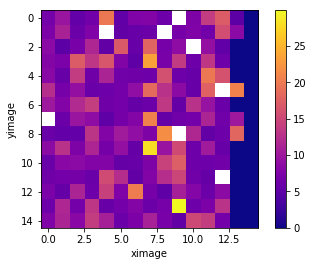

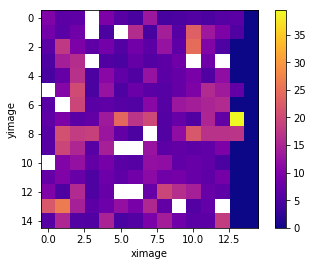

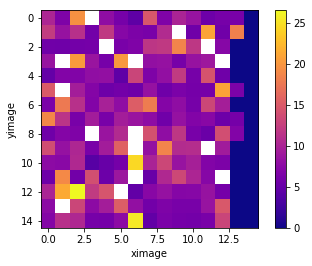

In [260]:
imageNo = 0

for x in range(len(psf)):
    plt.imshow(psf[x],cmap='plasma',interpolation='nearest')
    plt.colorbar()
    plt.xlabel('ximage')
    plt.ylabel('yimage')
    plt.show()

In [219]:
psf[2]

[[1.534, 1.9850000000000001, 1.742, 2.0640000000000001, 1.5109999999999999],
 [3.7949999999999999, 1.464, 1.6679999999999999, 1.542, 5.4119999999999999],
 [1.7035, 2.6520000000000001, 2.3359999999999999, 2.2859999999999996, 1.484],
 [2.1240000000000001,
  1.6625000000000001,
  1.5089999999999999,
  1.7030000000000001,
  1.6950000000000001],
 [2.0960000000000001,
  1.6405000000000001,
  1.7330000000000001,
  1.8210000000000002,
  4.548]]

In [87]:
xcoords = ['pillow','pillow']
ycoords = ['pillow','pillow']

with open('starlist','w') as f:
    writer = csv.writer(f,delimiter=' ')
    writer.writerows(zip(xcoords,ycoords))

In [38]:
df = outTable.to_pandas()
newdf = df.nlargest(1050,'FLUX_ISO')

In [39]:
df2 = newdf[50:1050]

In [45]:
dfbottomtotop = []
os.chdir('/home/mj1e16/iraf/')
length = len(df2)
nsegs = 25
segment = length/nsegs

for segs in range(nsegs):
    low = segs*segment
    high = low+segment
    regiondf = df2.loc[(df['Y_IMAGE'] >= low) & (df['Y_IMAGE'] <= high)]
    xcoords = regiondf['X_IMAGE'].tolist()
    ycoords = regiondf['Y_IMAGE'].tolist()
    with open('starlist','w') as f:
        writer = csv.writer(f,delimiter=' ')
        writer.writerows(zip(xcoords,ycoords))
    psfmeasure('kplr2009115002613_ffi-cal.fits[2]',coords='markall',logfile='logfile_{}_{}'.format('imagename',segs),imagecur='starlist') 


** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Mon 20:01:47 10-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
kplr20091150026  954.77   30.30    0.59   1.471    0.23      54
                 636.38   32.52    1.80   1.354    0.35      75
                 771.76   20.63    2.15   1.672    0.20      54
                 934.28   34.87    2.44   1.308    0.31      54
                 157.70   28.33    0.00   1.999    0.15      71
                1104.99   36.19    4.83   1.293    0.44       4
                 662.95   33.38    2.71   1.942    0.56     -14
                 367.21   29.42    3.22   1.552    0.41       5
                 262.46   23.87    3.27   1.594    0.41      58
                1001.37   35.09    3.51   1.226    0.35      51
                1031.08   33.89    3.57   1.334    0.30      54
                1116.13   14.11    6.72  22.015    0.94     -52


In [15]:
from iraf import psfmeasure

In [10]:
os.chdir('/home/mj1e16/iraf/')

In [20]:
psfmeasure('kplr2009115002613_ffi-cal.fits[44]',coords='markall',logfile='logfile',imagecur='starlist') #)

** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Mon 19:56:52 10-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
kplr20091150026  684.11  500.74    3.64   1.407    0.17     -69
                 674.83  732.79    0.00   3.940    0.84     -88
                 153.29  644.73    0.24   3.406    0.70     -89

  Average full width at half maximum (FWHM) of 3.6589
